# Convert a graph to XYZ coordinates
Illustrates how to use the "structure to XYZ" features of the `hydronet` library

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hydronet.inverting import convert_directed_graph_to_xyz
from hydronet.data import graph_from_dict, atoms_from_dict
from hydronet.importing import infer_water_cluster_bonds, make_nfp_network
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
from ttm.ase import TTMCalculator
from ase.optimize.bfgs import BFGS
from ase.io.xyz import write_xyz
from io import StringIO
from tqdm import tqdm
import pandas as pd
import gzip
import json
import os

Configuration

In [2]:
audit_cluster_size = 18
max_audit_size = 100

## Simple Example
Show a step-by-step example

Load one from disk

In [3]:
with gzip.open('../data/output/coarse_test.json.gz') as fp:
    graph_dict = json.loads(fp.readline().strip())
graph = graph_from_dict(graph_dict)

Convert it to atoms

In [4]:
atoms = convert_directed_graph_to_xyz(graph)
atoms

Atoms(symbols='H44O22', pbc=False)

Print as an XYZ file

In [5]:
fp = StringIO()
write_xyz(fp, atoms)
print(fp.getvalue()[:256] + "...")

66
Properties=species:S:1:pos:R:3 pbc="F F F"
O       -1.62148274       0.25234426      -1.43203418
H       -1.06313978       0.08244097      -0.66465239
H       -2.37500291      -0.13061349      -0.96831063
O       -2.65751415      -4.13491971      -0.392...


Load the original

In [6]:
with gzip.open('../data/output/geom_test.json.gz') as fp:
    xyz_dict = json.loads(fp.readline().strip())

In [7]:
orig_atoms = atoms_from_dict(xyz_dict)

Compare the energy

In [8]:
calc = TTMCalculator()

In [9]:
print(f'Original structure: {calc.get_potential_energy(orig_atoms):.2f} kcal/mol')
print(f'New structure: {calc.get_potential_energy(atoms):.2f} kcal/mol')

Original structure: -227.75 kcal/mol
New structure: 46.43 kcal/mol


Optimize the energy

In [10]:
atoms.set_calculator(calc)

In [11]:
opt = BFGS(atoms, logfile=os.devnull)

In [12]:
%%time
opt.run()

CPU times: user 3min 7s, sys: 8.66 s, total: 3min 16s
Wall time: 6.16 s


True

In [13]:
print(f'Original structure: {calc.get_potential_energy(orig_atoms):.4f} kcal/mol')
print(f'New structure after relaxation: {calc.get_potential_energy(atoms):.4f} kcal/mol')

Original structure: -227.7452 kcal/mol
New structure after relaxation: -224.4933 kcal/mol


## Evaluate Performance
Do energies fo the graphs correlate with the energy of the relaxed structures

In [14]:
data = pd.read_json('../data/output/coarse_test.json.gz', lines=True)
print(f'Loaded {len(data)} records')

Loaded 223448 records


In [15]:
data.query(f'n_waters=={audit_cluster_size}', inplace=True)
if len(data) > max_audit_size:
    data = data.sample(max_audit_size)
data.reset_index(inplace=True)
print(f'Downselected to {len(data)} clusters of size {audit_cluster_size}')

Downselected to 100 clusters of size 18


In [16]:
results = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    # Invert the graph
    graph = graph_from_dict(row)
    atoms = convert_directed_graph_to_xyz(graph)
    
    # Relax the structure
    start_eng = calc.get_potential_energy(atoms)
    atoms.set_calculator(calc)
    opt = BFGS(atoms, logfile=os.devnull)
    opt.run()
    end_eng = calc.get_potential_energy(atoms)
    
    # Store the results
    results.append({
        'init_energy': start_eng,
        'num_steps': opt.nsteps,
        'relaxed_energy': end_eng
    })
opt_results = pd.DataFrame(results)

100%|██████████| 100/100 [05:15<00:00,  3.15s/it]


In [17]:
for c in opt_results.columns:
    data[c] = opt_results[c]

Plot the performance

In [18]:
print(f'R^2 score: {r2_score(data["energy"], data["relaxed_energy"]):.2f}')
print(f'Spearman Rho: {spearmanr(data["energy"], data["relaxed_energy"])[0]:.2f}')

R^2 score: 0.54
Spearman Rho: 0.84


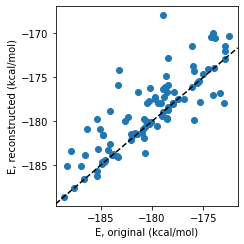

In [19]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(data['energy'], data['relaxed_energy'])

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
ax.set_xlabel('E, original (kcal/mol)')
ax.set_ylabel('E, reconstructed (kcal/mol)')

fig.tight_layout()